In [1]:
import sys
import pdb
import numpy as np
import GPyOpt

from matplotlib import pyplot as plt

from qiskit import Aer, execute, transpile, QuantumCircuit
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator as wpo
from qiskit.aqua.operators import TPBGroupedWeightedPauliOperator, Z2Symmetries
from qiskit.aqua.algorithms import ExactEigensolver

# from qiskit.chemistry import FermionicOperator
# from qiskit.chemistry.drivers import PySCFDriver, UnitsType
# from qiskit.chemistry.components.initial_states import HartreeFock
# from qiskit.chemistry.components.variational_forms import UCCSD

sys.path.insert(0, '../core/')
from cost_weighted_ops import *
from ansatz import *
import utilities as ut

In [2]:
def get_qubit_op(dist):
    """ """
    from qiskit.chemistry import FermionicOperator
    from qiskit.chemistry.drivers import PySCFDriver, UnitsType
    from qiskit.aqua.operators import Z2Symmetries
    
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity', threshold=1E-8)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp,num_particles)
    shift = repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
dist = 0.7

# make qubit ops
qubitOp,num_particles,num_spin_orbitals,shift = get_qubit_op(dist)

In [4]:
num_particles

2

In [3]:
n = 2
depth = 3
ansatz = RandomAnsatz(n,depth)

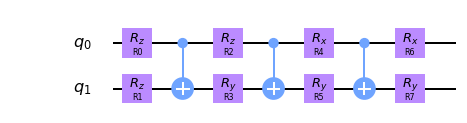

In [4]:
ansatz.circuit.draw()

In [5]:
NB_SHOTS_DEFAULT = 1024
OPTIMIZATION_LEVEL_DEFAULT = 3
# ===================
# Choose a backend using the custom backend manager and generate an instance
# ===================
bem = ut.BackendManager()
bem.get_current_status()
chosen_device = int(input('SELECT IBM DEVICE:'))
bem.get_backend(chosen_device, inplace=True)
inst = bem.gen_instance_from_current(nb_shots=NB_SHOTS_DEFAULT,
                                     optim_lvl=OPTIMIZATION_LEVEL_DEFAULT)
inst_test = bem.gen_instance_from_current(nb_shots=8192,
                                          optim_lvl=OPTIMIZATION_LEVEL_DEFAULT)

1 :    BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.0.6', operational=True, pending_jobs=4, status_msg='active')
2 :    BackendStatus(backend_name='ibmq_vigo', backend_version='1.0.2', operational=True, pending_jobs=11, status_msg='active')
3 :    BackendStatus(backend_name='qasm_simulator', backend_version='0.4.1', operational=True, pending_jobs=0, status_msg='')


SELECT IBM DEVICE: 3


Generated a new quantum instance
Generated a new quantum instance


In [6]:
dist = 0.7

# make qubit ops
qubitOp,num_particles,num_spin_orbitals,shift = get_qubit_op(dist)

# get exact energy
result = ExactEigensolver(qubitOp).run()
exact_energy = result['energy'] #+shift
print('target E = {0:.6g}'.format(result['energy']))

# make Cost objs
h2_fidelity = CostWeightedOps(ansatz=ansatz, instance=inst, operators=qubitOp)
h2_fidelity_test = CostWeightedOps(ansatz=ansatz, instance=inst_test, operators=qubitOp)

target E = -1.89216


(-0.5172844252374612+0j)
(-1.0771630089048922+0j)
(-0.5855165656233645+0j)
(-1.0096122070606146+0j)
(-0.9325842231445138+0j)
(-1.4571818860808958+0j)
(-0.6634681354685514+0j)
(-0.3581504306225244+0j)
(-1.299523016953629+0j)
(-1.0673239965936512+0j)
(-1.2090128345243976+0j)
(-1.3315735052022069+0j)
(-1.155840868081458+0j)
(-1.0295935131126575+0j)
(-1.0743162065960499+0j)
(-1.0814440538266477+0j)
(-0.5267154803676389+0j)
(-1.7481225904270568+0j)
(-1.209724853447895+0j)
(-1.2335683450004915+0j)
(-1.060268679067159+0j)
(-0.6711964193991891+0j)
(-0.892199985965482+0j)
(-1.2140296836447326+0j)
(-1.7190015561186929+0j)
(-1.3514456398431909+0j)
(-1.320896562827516+0j)
(-0.6886727032373821+0j)
(-1.0648686206849909+0j)
(-1.3584524241617053+0j)
start optim
(-1.42558927786733+0j)
(-1.71596723953597+0j)
(-1.1597463176366591+0j)
(-1.752700197197425+0j)
(-1.5393198384251816+0j)
(-1.5171951990514396+0j)
(-1.7348220345204775+0j)
(-1.780820874704793+0j)
(-1.6786821352558658+0j)
(-1.5408542458921335+0j)


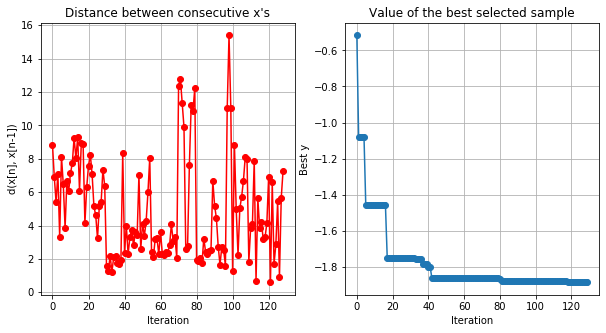

In [25]:
# ===================
# BO Optim
# No noise / Use of fidelity
# 20/25 works
#EPS = np.pi/2
#DOMAIN_RED = [(x-EPS, x+EPS) for x in X_SOL]
# ===================
# setup
NB_INIT = 30
NB_ITER = 100
DOMAIN_FULL = [(0, 2*np.pi) for i in range(ansatz.nb_params)]
DOMAIN_BO = [{'name': str(i), 'type': 'continuous', 'domain': d} for i, d in enumerate(DOMAIN_FULL)]
bo_args = ut.gen_default_argsbo()
bo_args.update({'domain': DOMAIN_BO,'initial_design_numdata':NB_INIT})
cost_bo = h2_fidelity

#optim
Bopt = GPyOpt.methods.BayesianOptimization(cost_bo, **bo_args)    
print("start optim")
Bopt.run_optimization(max_iter = NB_ITER, eps = 0)

# Results found
(x_seen, y_seen), (x_exp,y_exp) = Bopt.get_best()
h2_fidelity_test(x_seen)
h2_fidelity_test(x_exp)
print(Bopt.model.model)
Bopt.plot_convergence()

In [26]:
(x_seen, y_seen), (x_exp,y_exp) = Bopt.get_best()

In [27]:
print(h2_fidelity_test(x_exp)-exact_energy)

(-1.872542963366751+0j)
(0.01961393487060037+0j)


In [24]:
print(h2_fidelity_test(x_exp)-exact_energy)

(-1.8663091269928176+0j)
(0.025847771244533746+0j)


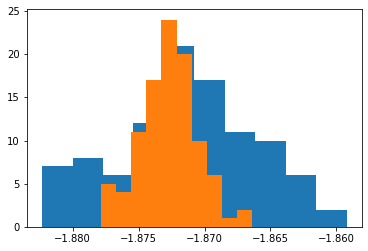

In [17]:
fig,ax = plt.subplots()
plt.hist(low_counts_measurements)
plt.hist(high_count_measurements)
plt.show()

In [16]:
rand_vals = 2*np.pi*np.random.random(ansatz.nb_params)

high_count_measurements = []
for i in range(100):
    high_count_measurements.append(h2_fidelity_test(x_exp))

low_counts_measurements = []
for i in range(100):
    low_counts_measurements.append(h2_fidelity(x_exp))

(-1.8707572612933507+0j)
(-1.8721432650307734+0j)
(-1.8711754496321007+0j)
(-1.8715065701294487+0j)
(-1.872823661244613+0j)
(-1.8718060927937106+0j)
(-1.8723365602836055+0j)
(-1.8700580402931113+0j)
(-1.8706261573558058+0j)
(-1.8716810405958806+0j)
(-1.8707760860797513+0j)
(-1.872124440244373+0j)
(-1.8703078099051438+0j)
(-1.8738540027422008+0j)
(-1.8718934954187407+0j)
(-1.872711382093468+0j)
(-1.8743095058701227+0j)
(-1.8722370541791462+0j)
(-1.8710628356973278+0j)
(-1.8685096695686862+0j)
(-1.8743780837087527+0j)
(-1.8721304919840878+0j)
(-1.8755516326233146+0j)
(-1.8758827531206623+0j)
(-1.871668602332823+0j)
(-1.8739477918905738+0j)
(-1.872430349431978+0j)
(-1.8747713955213876+0j)
(-1.8709693813325832+0j)
(-1.8695712741157315+0j)
(-1.866361918732109+0j)
(-1.8753334608443675+0j)
(-1.8741471388831201+0j)
(-1.8698082706810786+0j)
(-1.871518673608878+0j)
(-1.8739286323205453+0j)
(-1.871556323181678+0j)
(-1.871930810207913+0j)
(-1.870101741605626+0j)
(-1.8735914600834827+0j)
(-1.877031